## data generation

In [1]:
from locally_connected import LocallyConnected
from lbfgsb_scipy import LBFGSBScipy
from trace_expm import trace_expm
from sklearn.metrics import f1_score
import torch
import torch.nn as nn
import numpy as np
import scipy.sparse
import GraphNOTEARS
import notears_torch_version
import lasso
import dynotears
import utils as ut
import matplotlib.pyplot as plt
import networkx as nx
import dgl
import random
import utils as ut
import dgl.function as fn
import torch.nn as nn
import torch.nn.functional as F
from dgl import DGLGraph
import pandas as pd
#device = torch.device("cuda:0")
device = torch.device("cuda")

D:\Anaconda\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
D:\Anaconda\lib\site-packages\numpy\.libs\libopenblas.TXA6YQSD3GCQQC22GEQ54J2UDCXDXHWN.gfortran-win_amd64.dll
D:\Anaconda\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  stacklevel=1)

Bad key "text.kerning_factor" on line 4 in
D:\Anaconda\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution
Using backend: pytorch


In [2]:
def data_pre(n, d, s0, w_graph_type, p_graph_type, sem_type,ratio):
    #binary W
    w_true = ut.simulate_dag(d, s0, w_graph_type)
    #weighted W
    w_mat = ut.simulate_parameter(w_true)
    w_test_mat=w_mat.copy()
    #A
    adj1 = ut.generate_adj(n) 
    #node to target
    num_target=np.nonzero(w_mat[:,-1])[0]#4,14
    n_suprious=-1.0
    suprious_dict={}
    #if no suprious variable existed
    if len(num_target)==0:
        return w_mat,w_mat, w_mat, w_mat,w_mat,w_mat,n_suprious
    else:
        #create the spurious variable
        for i in range(len(num_target)):
            suprious_list=np.nonzero(w_mat[num_target[i],:])[0]#12

            for j in range(len(suprious_list)): 
                suprious=suprious_list[j]
                #count the number of suprious variable
                if suprious not in suprious_dict:
                    suprious_dict[suprious]=1
                    n_suprious+=1
                    #remove other outgoing link
                    w_mat[suprious,:]=0 #12,0
                    w_test_mat[suprious,:]=0
                    #print(suprious)
                    #revert the link in the test
                    if suprious!=d-1:
                        w_test_mat[num_target[i],suprious]=ratio*w_test_mat[num_target[i],suprious]
                
                
    num_step = 5 #cannot work if num_step=1
    #initial X0=X0W+B
    Xbase = []
    Xbase1 = ut.simulate_linear_sem(w_mat, n, sem_type, noise_scale=0.5)
    #X1=X1W+AX0W+B
    for i in range(num_step):
        Xbase1 = ut.simulate_linear_sem_with_P(w_mat, w_mat, adj1@Xbase1, n, sem_type, noise_scale=1)
        Xbase.append(Xbase1)
        
    #test data
    Xbase_test = []
    Xbase1_test = ut.simulate_linear_sem(w_test_mat, n, sem_type, noise_scale=0.5)
    for i in range(num_step):
        Xbase1_test = ut.simulate_linear_sem_with_P(w_test_mat, w_test_mat, adj1@Xbase1_test, n, sem_type, noise_scale=1)
        Xbase_test.append(Xbase1_test)
    
    return Xbase,Xbase_test, adj1, w_true,w_mat,w_test_mat,n_suprious

In [3]:
def count_accuracy(G_true: nx.DiGraph,
                   G: nx.DiGraph) -> tuple:
    """Compute FDR, TPR, and SHD for a matrix B.
        
        Args:
        G_true: ground truth graph
        G: predicted graph
        
        Returns:
        fdr: (reverse + false positive) / prediction positive
        tpr: (true positive) / condition positive
        shd: undirected extra + undirected missing + reverse
        """
    B_true = nx.to_numpy_array(G_true) != 0
    B = nx.to_numpy_array(G) != 0
    d = B.shape[0]
    # linear index of nonzeros
    pred = np.flatnonzero(B)
    cond = np.flatnonzero(B_true)
    cond_reversed = np.flatnonzero(B_true.T)
    cond_skeleton = np.concatenate([cond, cond_reversed])
    # true pos
    true_pos = np.intersect1d(pred, cond, assume_unique=True)
    # false pos
    false_pos = np.setdiff1d(pred, cond_skeleton, assume_unique=True)
    # reverse
    extra = np.setdiff1d(pred, cond, assume_unique=True)
    reverse = np.intersect1d(extra, cond_reversed, assume_unique=True)
    # compute ratio
    pred_size = len(pred)
    cond_neg_size = 0.5 * d * (d - 1) - len(cond)
    fdr = float(len(reverse) + len(false_pos)) / max(pred_size, 1)
    tpr = float(len(true_pos)) / max(len(cond), 1)
    # structural hamming distance
    B_lower = np.tril(B + B.T)
    pred_lower = np.flatnonzero(B_lower)
    cond_lower = np.flatnonzero(np.tril(B_true + B_true.T))
    extra_lower = np.setdiff1d(pred_lower, cond_lower, assume_unique=True)
    missing_lower = np.setdiff1d(cond_lower, pred_lower, assume_unique=True)
    shd = len(extra_lower) + len(missing_lower) + len(reverse)
    return fdr, tpr, shd

## NOTEARS

In [4]:
from scipy.special import expit as sigmoid
import scipy.optimize as sopt
import scipy.linalg as slin
import scipy.sparse as sp
from notears.locally_connected import LocallyConnected
from notears.lbfgsb_scipy import LBFGSBScipy
from notears.trace_expm import trace_expm
import torch
import torch.nn as nn
import numpy as np
import math

def notears_linear(X, lambda1, loss_type, max_iter=100, h_tol=1e-8, rho_max=1e+16, w_threshold=0.3):
    """Solve min_W L(W; X) + lambda1 ‖W‖_1 s.t. h(W) = 0 using augmented Lagrangian.

    Args:
        X (np.ndarray): [n, d] sample matrix
        lambda1 (float): l1 penalty parameter
        loss_type (str): l2, logistic, poisson
        max_iter (int): max num of dual ascent steps
        h_tol (float): exit if |h(w_est)| <= htol
        rho_max (float): exit if rho >= rho_max
        w_threshold (float): drop edge if |weight| < threshold

    Returns:
        W_est (np.ndarray): [d, d] estimated DAG
    """
    def _loss(W):
        """Evaluate value and gradient of loss."""
        M = X @ W
        if loss_type == 'l2':
            R = X - M
            loss = 0.5 / X.shape[0] * (R ** 2).sum()
            G_loss = - 1.0 / X.shape[0] * X.T @ R
        elif loss_type == 'logistic':
            loss = 1.0 / X.shape[0] * (np.logaddexp(0, M) - X * M).sum()
            G_loss = 1.0 / X.shape[0] * X.T @ (sigmoid(M) - X)
        elif loss_type == 'poisson':
            S = np.exp(M)
            loss = 1.0 / X.shape[0] * (S - X * M).sum()
            G_loss = 1.0 / X.shape[0] * X.T @ (S - X)
        else:
            raise ValueError('unknown loss type')
        return loss, G_loss

    def _h(W):
        """Evaluate value and gradient of acyclicity constraint."""
        E = slin.expm(W * W)  # (Zheng et al. 2018)
        h = np.trace(E) - d
        #     # A different formulation, slightly faster at the cost of numerical stability
        #     M = np.eye(d) + W * W / d  # (Yu et al. 2019)
        #     E = np.linalg.matrix_power(M, d - 1)
        #     h = (E.T * M).sum() - d
        G_h = E.T * W * 2
        return h, G_h

    def _adj(w):
        """Convert doubled variables ([2 d^2] array) back to original variables ([d, d] matrix)."""
        return (w[:d * d] - w[d * d:]).reshape([d, d])

    def _func(w):
        """Evaluate value and gradient of augmented Lagrangian for doubled variables ([2 d^2] array)."""
        W = _adj(w)
        loss, G_loss = _loss(W)
        h, G_h = _h(W)
        obj = loss + 0.5 * rho * h * h + alpha * h + lambda1 * w.sum()
        G_smooth = G_loss + (rho * h + alpha) * G_h
        g_obj = np.concatenate((G_smooth + lambda1, - G_smooth + lambda1), axis=None)
        return obj, g_obj

    n, d = X.shape
    w_est, rho, alpha, h = np.zeros(2 * d * d), 1.0, 0.0, np.inf  # double w_est into (w_pos, w_neg)
    bnds = [(0, 0) if i == j else (0, None) for _ in range(2) for i in range(d) for j in range(d)]
    if loss_type == 'l2':
        X = X - np.mean(X, axis=0, keepdims=True)
    for _ in range(max_iter):
        w_new, h_new = None, None
        while rho < rho_max:
            sol = sopt.minimize(_func, w_est, method='L-BFGS-B', jac=True, bounds=bnds)
            w_new = sol.x
            h_new, _ = _h(_adj(w_new))
            if h_new > 0.25 * h:
                rho *= 10
            else:
                break
        w_est, h = w_new, h_new
        alpha += rho * h
        if h <= h_tol or rho >= rho_max:
            break
    W_est = _adj(w_est)
    W_est[np.abs(W_est) < w_threshold] = 0
    return W_est

In [8]:
torch.set_default_dtype(torch.double)
np.set_printoptions(precision=3)

torch.manual_seed(12345)
ut.set_random_seed(12345)

n = 50 #number of people

d = 20 #number of features


w_graph_type = 'ER'
p_graph_type = 'ER' 
sem_type = 'exp'
s0 =  d
#params
ratio=-1
threshold=0.3
output=pd.DataFrame(columns=["FDR","TPR","SHD","model"])
ith=0
replicates=50
while ith<replicates*2:
    print("-------------------the",ith//2,"iteration------------------")
    #create data
    Xlags,Xlags_test, adj1, w_true,w_mat,w_test_mat,n_suprious = data_pre(n, d, s0, w_graph_type,p_graph_type, sem_type,ratio)
    if n_suprious<=0:
        continue
    Xlags_torch = torch.Tensor(np.array(Xlags))
    print("finish data!")
    #fit the causal graph
    adj1_torch = torch.Tensor(adj1)
    model_1 = GraphNOTEARS.model_p1_MLP(dims=[d, n, 1], bias=True)
    W_est_1, P1_est_1 = GraphNOTEARS.linear_model(model_1, Xlags_torch, adj1_torch,  lambda1 = 0.01, lambda2 = 0.01, lambda3 = 0.01)
    print("finish fit graph!")
    #NOTEARS
    w_notears=notears_linear(np.asarray(Xlags).reshape(250,d), lambda1=0.1, loss_type='l2')
    ##evaluate
    #true label
    w_mat[abs(w_mat)<threshold] = 0
    base_graph=nx.from_numpy_matrix(w_mat,create_using=nx.DiGraph)
    
    #proposed
    W_est_1[abs(W_est_1)<threshold] = 0
    proposed_estimate=nx.from_numpy_matrix(W_est_1,create_using=nx.DiGraph)
    
    ##NOTEARS
    w_notears[abs(w_notears)<threshold] = 0
    notears_estimate=nx.from_numpy_matrix(w_notears,create_using=nx.DiGraph)
    
    #METRICS
    FDR,TPR,SHD=count_accuracy(base_graph,proposed_estimate)
    output.loc[ith]=[FDR,TPR,SHD,"proposed"]
    ith+=1
    FDR,TPR,SHD=count_accuracy(base_graph,notears_estimate)
    output.loc[ith]=[FDR,TPR,SHD,"NOTEARS"]
    
    ith+=1
    if ith %20==0:
        print(output.groupby("model").mean())

-------------------the 0 iteration------------------
finish data!
finish fit graph!
-------------------the 1 iteration------------------
-------------------the 1 iteration------------------
-------------------the 1 iteration------------------
finish data!
finish fit graph!
-------------------the 2 iteration------------------
-------------------the 2 iteration------------------
finish data!
finish fit graph!
-------------------the 3 iteration------------------
-------------------the 3 iteration------------------
-------------------the 3 iteration------------------
finish data!
finish fit graph!
-------------------the 4 iteration------------------
finish data!
finish fit graph!
-------------------the 5 iteration------------------
finish data!
finish fit graph!
-------------------the 6 iteration------------------
finish data!
finish fit graph!
-------------------the 7 iteration------------------
finish data!
finish fit graph!
-------------------the 8 iteration------------------
finish dat

In [9]:
output["SHD"]=output["SHD"].astype(int)

In [10]:
output.groupby("model").mean()

,FDR,TPR,SHD
model,,,
NOTEARS,0.074400,0.918144,2.28
proposed,0.118277,0.921466,2.42


In [7]:
np.asarray(Xlags).shape

(5, 50, 20)

In [89]:
output.groupby("model").mean()

,FDR,TPR,SHD
model,,,
NOTEARS,0.072095,0.892397,1.08
proposed,0.117243,0.913794,1.16


In [76]:
output.groupby("model").mean()

,FDR,TPR
model,,
NOTEARS,0.072095,0.892397
proposed,0.117243,0.913794


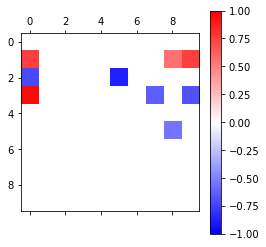

In [60]:
##True W
import matplotlib.pyplot as plt
w_mat[abs(w_mat)<0.3]=0
plt.matshow(w_mat,cmap = 'bwr', vmin = -1, vmax = 1)
plt.colorbar()
plt.show()

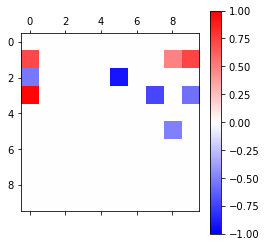

In [59]:
##Estimated
import matplotlib.pyplot as plt
W_est_1[abs(W_est_1)<0.3]=0
plt.matshow(W_est_1,cmap = 'bwr', vmin = -1, vmax = 1)
plt.colorbar()
plt.show()

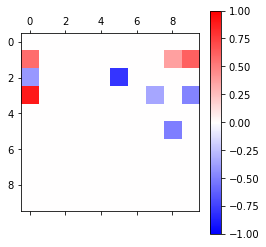

In [58]:
##notears
import matplotlib.pyplot as plt
w_notears[abs(w_notears)<0.3]=0
plt.matshow(w_notears,cmap = 'bwr', vmin = -1, vmax = 1)
plt.colorbar()
plt.show()